# Dataset ARPAL
Registrazione delle misure recuperate dal database di [ARPA Liguria](https://www.arpal.liguria.it).

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione secondo gli schemi esposti sotto;
2. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
3. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
4. [merging](#merging) del dataset.

## Data model
### Metadati
#### Dataset
| name   | source | kind   | description |
|--------|--------|--------|-------------|
| utf8() | utf8() | utf8() | utf8()      |
| pkey   | obs    | obs    | obs         |

Campi:
- in `name` l'identificativo (univoco) del dataset;
- in `source` un'indicazione di dove è possibile reperire i dati (possibilmente url); 
- in `kind` "national" o "regional";
- in `description` qualche informazione sul dataset.

#### Station
| dataset | id   | name | network | state | lon    | lat    | elevation | first_registration | last_registration | valid_days | previous_dataset | previous_id |
|---------|------|------|---------|-------|--------|--------|-----------|--------------------|-------------------|------------|------------------|-------------|
| utf8()  |int() |utf8()| utf8()  | utf8()|double()|double()| double()  | date32()           | date32()          | int()      | utf8()           | utf8()      |
| pkey    | pkey | obs  | obs     | obs   | obs    | obs    | obs       | obs                | obs               | obs        | fkey             | obs         |

I metadati delle stazioni che non rientrano nella tabella vanno in una tabella "extra" collegata tramite `dataset` e `id`.

### Data
| dataset   | station_id | variable | date     | value     |
|-----------|------------| -------- | -------- | --------- |
| utf8()    | int()      | utf8()   | date32() | float64() |
| pkey/fkey | pkey/fkey  | pkey     | pkey     | obs       |


## Caricamento librerie e dichiarazione del dataset
Scrivere nel file `load_daily.R` una funzione `dataset_spec()` che fornisca in lista le informazioni sul dataset da caricare nel database.

In [1]:
dataset <- "ARPAL"
state <- "Liguria"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(DBI, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")
add_ds_info(dataset, dataset_spec())


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



## Uniformazione dei dati
Produzione di un checkpoint da dati raw. Scrivere una funzione `load_daily_data.<dataset>(first_date, last_date)` nel file `load_daily.R` che restituisca un dizionario con elementi:
- `meta`: una tabella con (almeno) i campi da `dataset` a `state` compilati;
- `data`: una tabella Arrow già nel formato standard.

Le funzioni di `common_steps` si occupano di completare ed effettuare il checkpoint.


In [12]:
daily_dataset <- load_daily_data.arpal() |> prepare_daily_data()
save_checkpoint(daily_dataset$checkpoint, dataset, "raw")
write_extra_metadata(daily_dataset$extra_meta |> collect(), dataset, conns$stations)
rm(daily_dataset)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1926481,102.9,3880051,207.3,NA,2371550,126.7
Vcells,3459102,26.4,8388608,64.0,16384,4508087,34.4


## Controllo disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio a confronto con SCIA e ISAC.

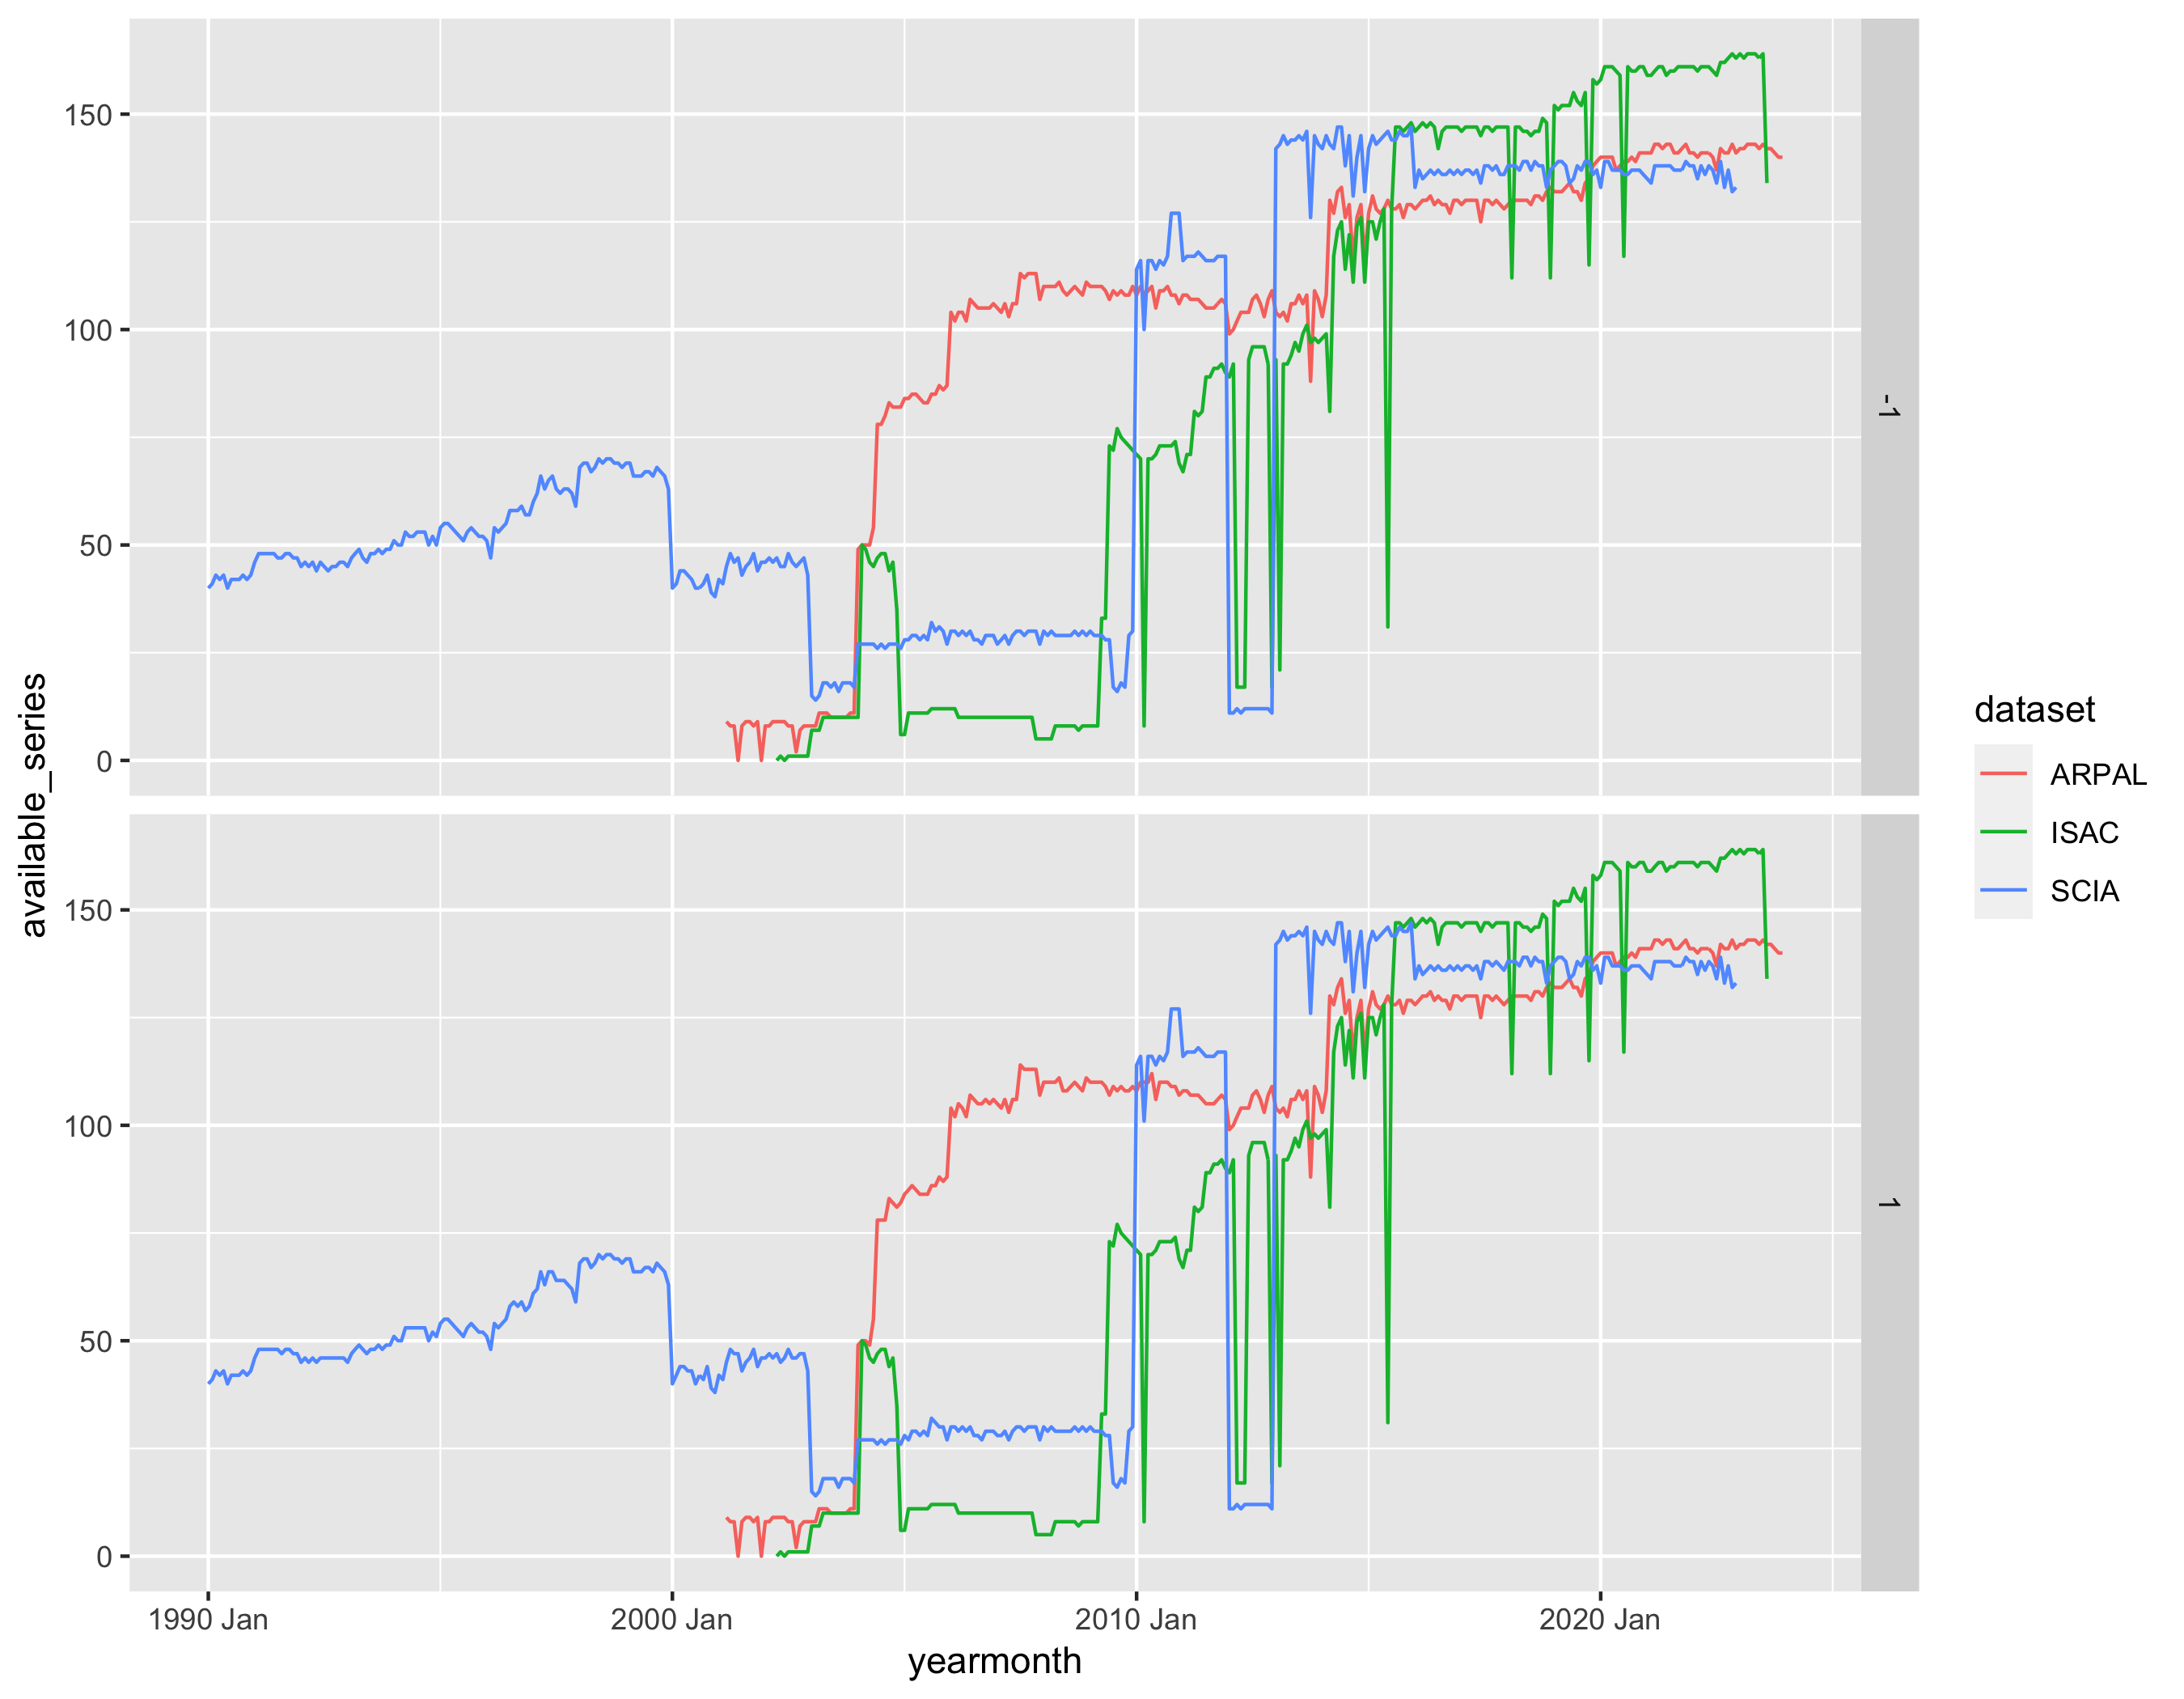

In [3]:
conn <- dbConnect(duckdb())
stations <- query_checkpoint(c(dataset, "SCIA", "ISAC"), "metadata", "raw", conn) |> filter(state == "Liguria")
state_data <- query_checkpoint(c(dataset, "SCIA", "ISAC"), "data", "raw", conn) |>
    filter(date >= as.Date("1990-01-01")) |>
    semi_join(stations, join_by(dataset == original_dataset, station_id == original_id))
c(p, ymonthly_avail) %<-% ymonthly_availabilities(state_data)
p

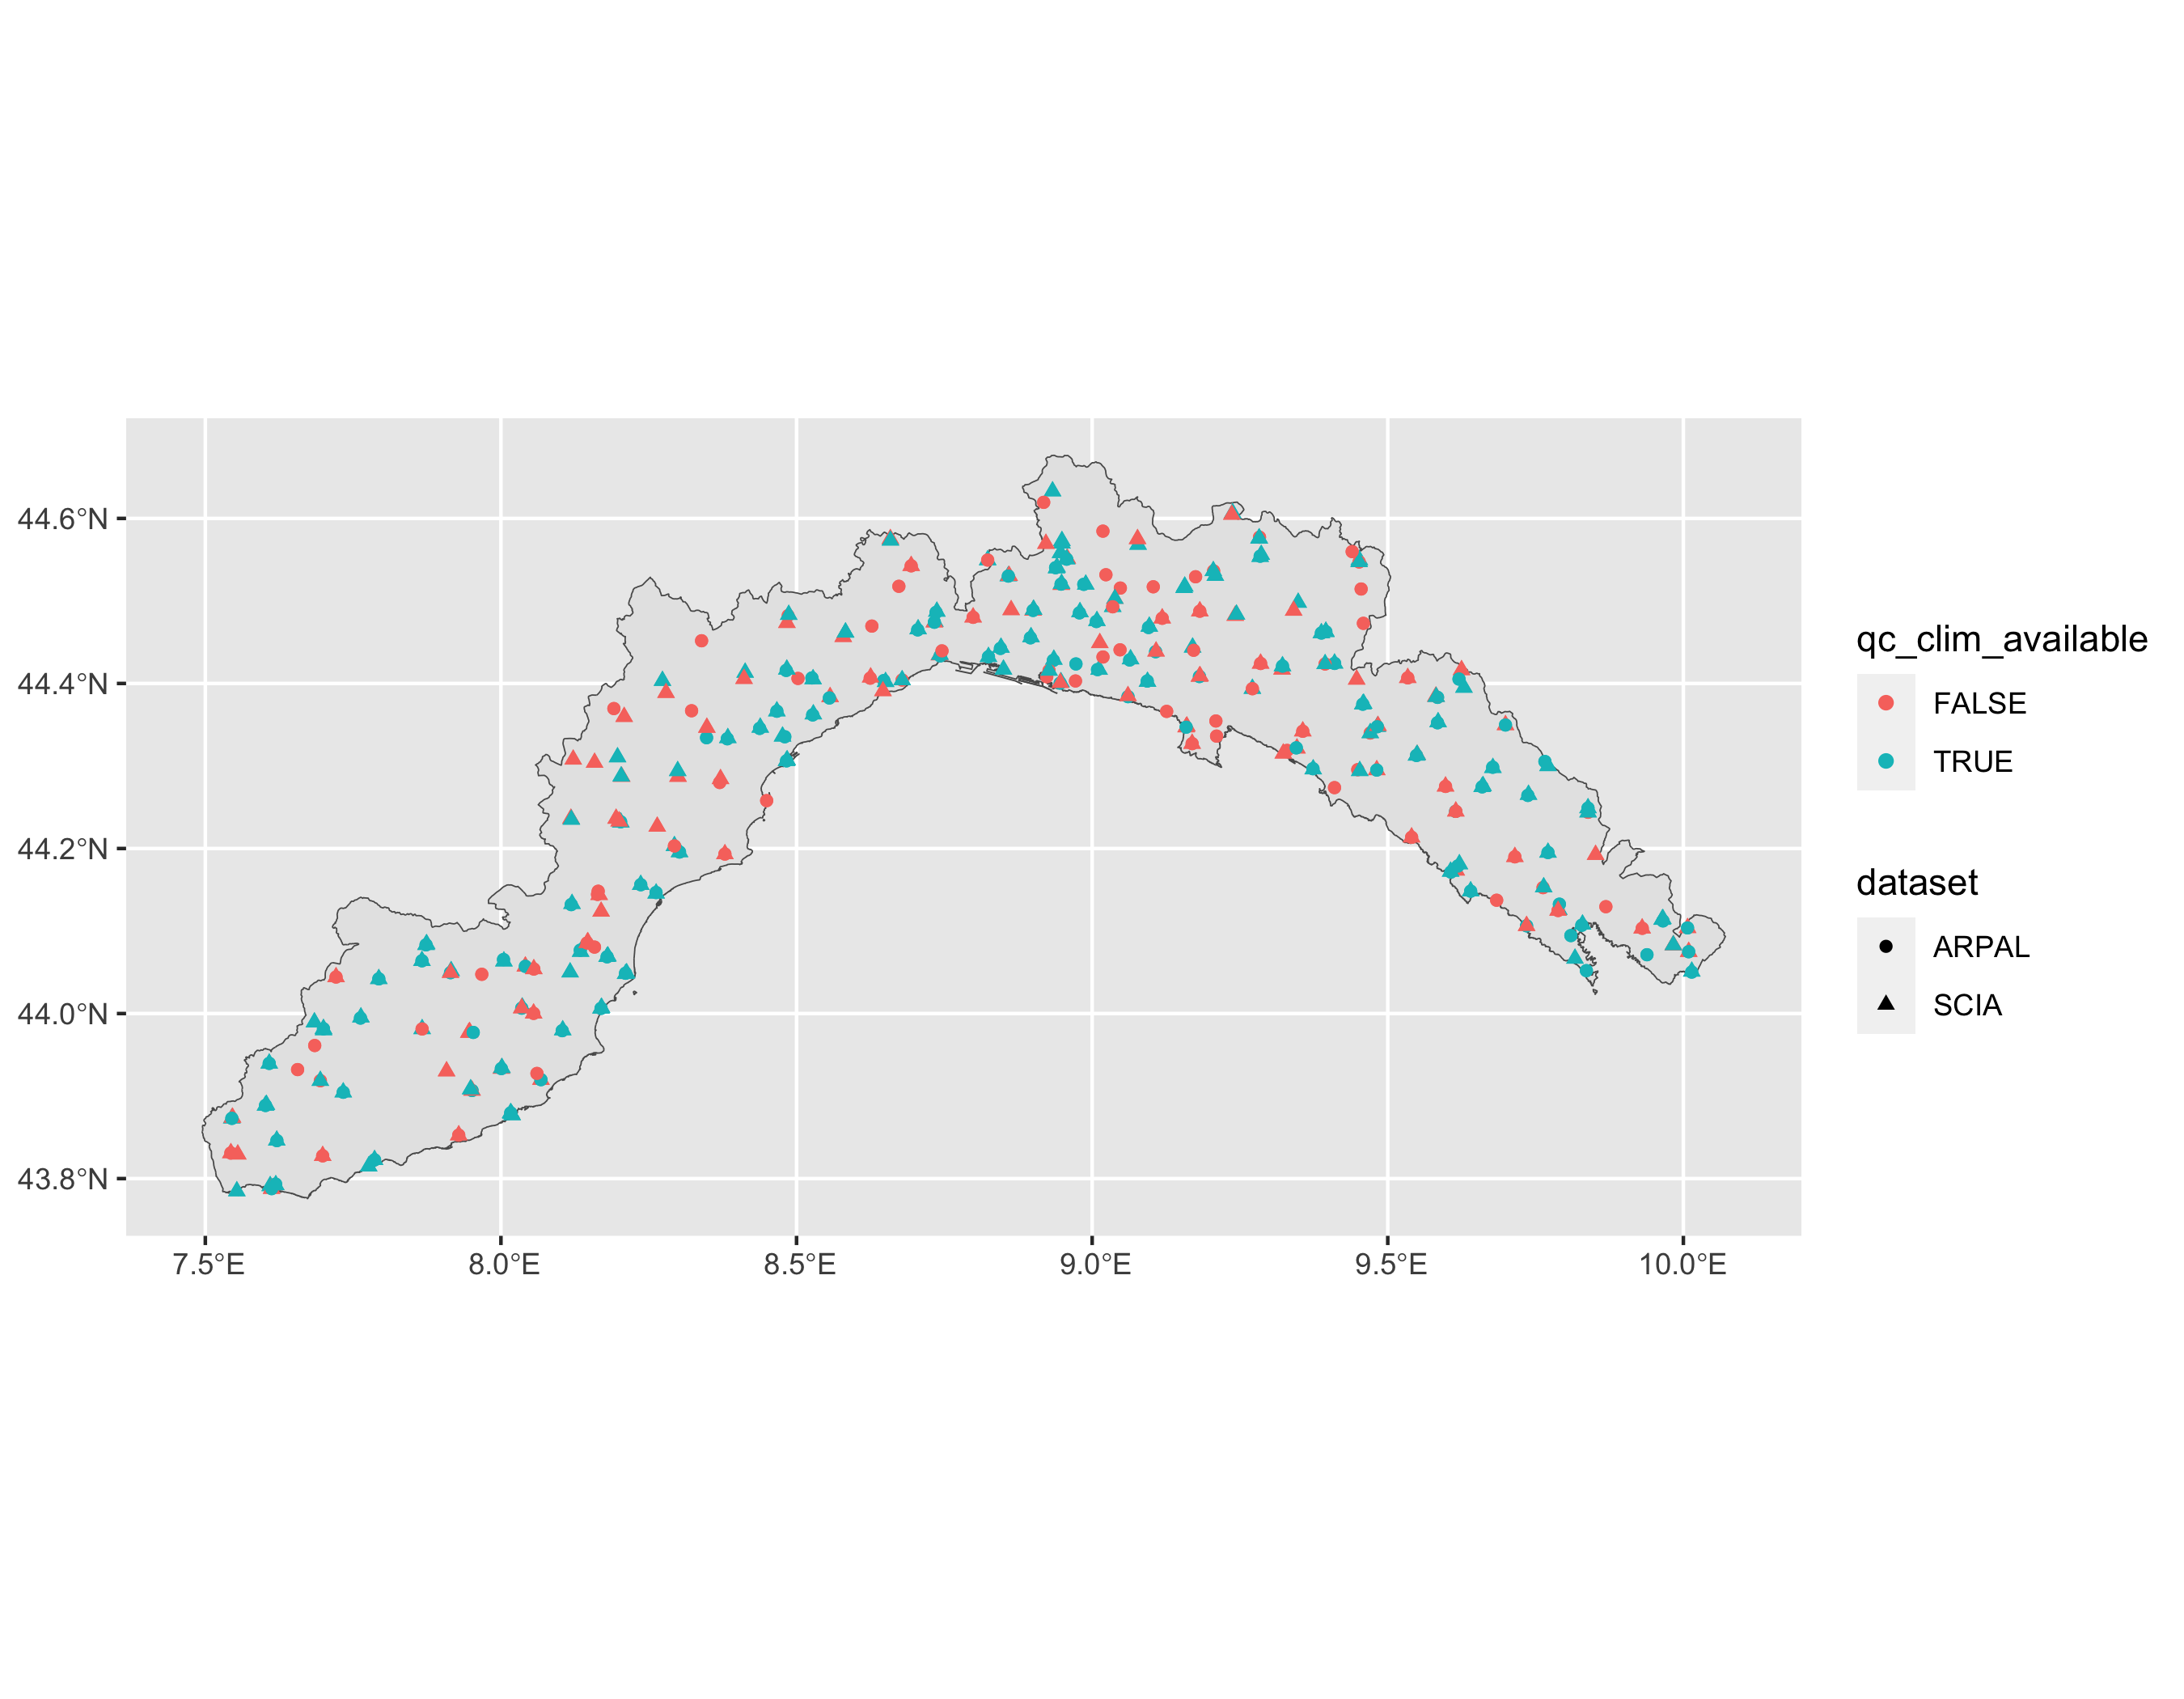

In [15]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, stations, state_boundaries)
p


In [10]:
climats |> filter(dataset == !!dataset) |> group_by(qc_clim_available, variable) |> count()

qc_clim_available,variable,n
<lgl>,<chr>,<int>
FALSE,T_MAX,81
FALSE,T_MIN,82
TRUE,T_MAX,99
TRUE,T_MIN,99


In [ ]:
rm(stations, state_data, ymonthly_avail, climats, p)
gc()


In [ ]:
# Lanciare da terminale
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(, "merged") |>
    launch_leaflet()